In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_html
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from statsmodels.stats.multicomp import MultiComparison

sns.set()

%matplotlib inline

import tjse

## Experimento 1

In [2]:
experimento1 = tjse.carregar_dados_experimento1()

experimento1.head()

,Chave,TUD,Stemmer,Coleção
0,201100200560443632531,576,NoStem,Segundo Grau - Acórdãos
1,201100200560443632531,517,Porter,Segundo Grau - Acórdãos
2,201100200560443632531,480,RSLP,Segundo Grau - Acórdãos
3,201100200560443632531,540,RSLP-S,Segundo Grau - Acórdãos
4,201100200560443632531,535,UniNE,Segundo Grau - Acórdãos


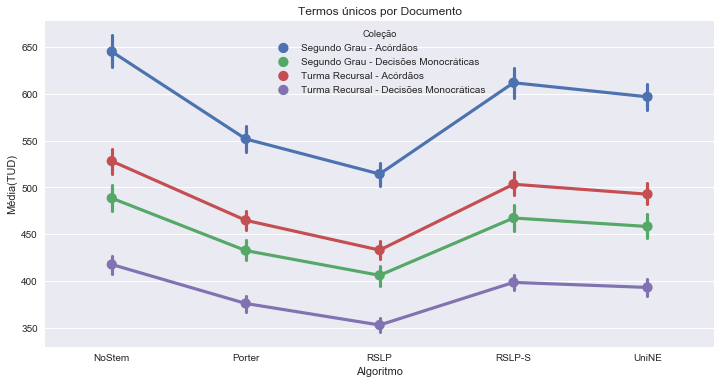

In [3]:
plt.figure(figsize=(12, 6))
graph1 = sns.pointplot(x="Stemmer", y="TUD", hue="Coleção",
                 data=experimento1, n_boot=1000)
graph1.set_ylabel('Média(TUD)')
graph1.set_xlabel('Algoritmo')
graph1.set_title('Termos únicos por Documento')
plt.show()

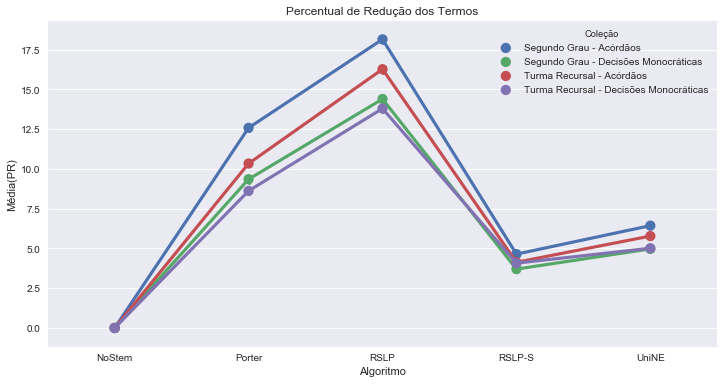

In [4]:
def percentual_de_reducao(dados):
    resultado = pd.pivot_table(dados, index=['Coleção', 'Chave'], columns='Stemmer', values='TUD') 
    
    resultado = resultado.assign(Porter = 100 - (resultado['Porter'] * 100) / resultado['NoStem'],
                                RSLPS = 100 - (resultado['RSLP-S'] * 100) / resultado['NoStem'],
                                RSLP = 100 - (resultado['RSLP'] * 100) / resultado['NoStem'],
                                UniNE = 100 - (resultado['UniNE'] * 100) / resultado['NoStem'],
                                NoStemTUD = resultado['NoStem'],
                                NoStem = 0.0)
    resultado.drop(['RSLP-S'], axis=1, inplace=True)
    resultado.rename(columns={'RSLPS': 'RSLP-S'}, inplace=True)
    
    return resultado

df_pr = percentual_de_reducao(experimento1)
df_graph = pd.melt(df_pr.reset_index(),
                   id_vars = ['Chave', 'Coleção'], 
                   value_vars=['NoStem','Porter','RSLP','RSLP-S','UniNE'], value_name='PR')
plt.figure(figsize=(12, 6))
graph2 = sns.pointplot(x="Stemmer", y="PR", hue="Coleção",
                 data=df_graph, n_boot=1000)
graph2.set_ylabel('Média(PR)')
graph2.set_xlabel('Algoritmo')
graph2.set_title('Percentual de Redução dos Termos')
plt.show()

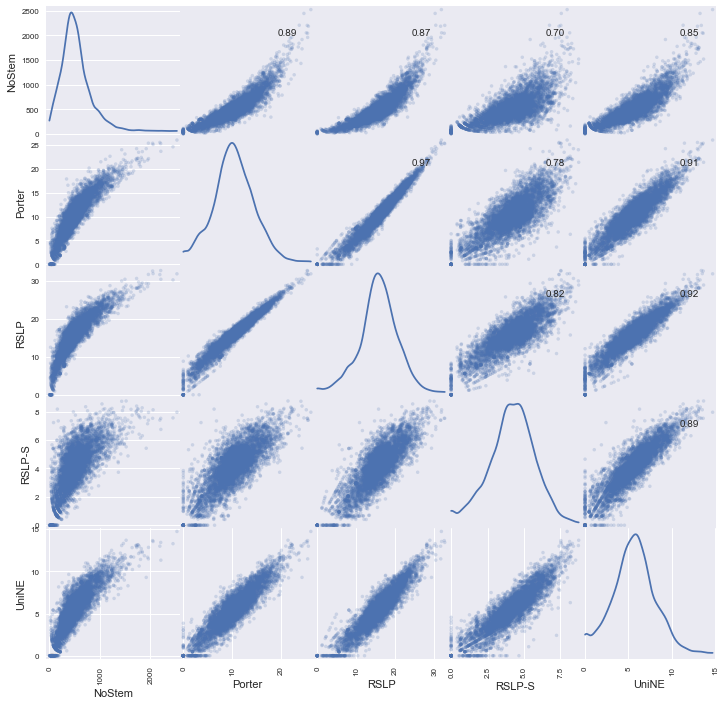

In [5]:
df_corr_graph = df_pr.drop(['NoStem'], axis=1).rename(columns={'NoStemTUD': 'NoStem'})
df_corr_graph = df_corr_graph[['NoStem', 'Porter', 'RSLP', 'RSLP-S', 'UniNE']]
axes = scatter_matrix(df_corr_graph, alpha=0.2, figsize=(12, 12), diagonal='kde')
corr = df_corr_graph.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

## Experimento 2

In [6]:
experimento2 = tjse.carregar_dados_experimento2()

experimento2.head()

,Qid,Valor,Coleção,Métrica,Stemmer
0,1,0.947681,ASG,MAP,NoStem
1,2,0.500000,ASG,MAP,NoStem
2,3,1.000000,ASG,MAP,NoStem
3,4,0.557677,ASG,MAP,NoStem
4,5,1.000000,ASG,MAP,NoStem


In [7]:
def bootstrap(values):
    valores = np.array([])
    for i in range(1000):
        valores = np.append(valores, np.random.choice(values, size=100, replace=True).mean())         
                    
    return valores

def plot_pairwise_tukeyhsd(colecao, metrica, grupos, grupos_labels):
    mc = MultiComparison(grupos, grupos_labels)
    result = mc.tukeyhsd()
    print(result)
    #Bug: https://github.com/statsmodels/statsmodels/issues/3584#issuecomment-289642981
    #fig = result.plot_simultaneous(comparison_name='NoStem')
    #fig.get_axes()[0].set_title('')

def plot_kde_normality(dados, col_name):
    colecao = dados.query('Coleção == @col_name')
    for metric in dados['Métrica'].unique():
        fig = plt.figure(figsize=(24, 16))
        grid = plt.GridSpec(2, 5, hspace=0.2, wspace=0.1)
        grupos = []
        grupos_labels = np.array([])
        df = colecao.query('Métrica == @metric')
        kde_ax = fig.add_subplot(grid[0, :])
        for i,stemmer in enumerate(df['Stemmer'].unique()):
            values = df.query("Stemmer == @stemmer")['Valor']
            values_bs = bootstrap(values)
            grupos.append(values_bs)
            grupos_labels = np.append(grupos_labels, np.repeat(stemmer, len(values_bs)))
            sns.kdeplot(values_bs, shade=True, ax = kde_ax)
            #Prability plot
            (osm, osr), (slope, intercept, r) = stats.probplot(values_bs)                
            ax_p = fig.add_subplot(grid[1, i])  
            line_color = kde_ax.get_lines()[i].get_color()                   
            ax_p.plot(osm, slope*osm + intercept, 'k-')
            ax_p.plot(osm, osr, 'o', color=line_color)            
            ax_p.set_title(stemmer)         
            ax_p.xaxis.set_ticks(np.linspace(-2,2,3))            
            ax_p.set_yticks(ax_p.get_yticks()[::3])     
            ax_p.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax_p.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            for spine in ax_p.spines.values():
                spine.set_visible(False)
            if i != 0:
                ax_p.set_ylabel('')
            else:
                ax_p.set_ylabel('Valores Ordenados')
            ax_p.set_xlabel('Quantis')
        
        plot_pairwise_tukeyhsd(col_name, metric, np.array(grupos).flatten(), grupos_labels)
            
        kde_ax.set_xlabel(metric)
        kde_ax.set_ylabel('Densidade de Probabilidade')
        kde_ax.set_xlim([0.5, 1])
        kde_ax.xaxis.get_major_ticks()[0].label1.set_visible(False)
        kde_ax.set_ylim([0, 30])
        kde_ax.yaxis.set_ticks(np.linspace(0,30,5))  
        kde_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        kde_ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))        
        for spine in kde_ax.spines.values():
                spine.set_visible(False)          

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0714  -0.0742 -0.0685  True 
NoStem  RSLP  -0.1969  -0.1998  -0.194  True 
NoStem RSLP-S -0.0201  -0.0229 -0.0172  True 
NoStem UniNE  -0.0502   -0.053 -0.0473  True 
Porter  RSLP  -0.1255  -0.1284 -0.1227  True 
Porter RSLP-S  0.0513   0.0484  0.0542  True 
Porter UniNE   0.0212   0.0183  0.024   True 
 RSLP  RSLP-S  0.1768   0.174   0.1797  True 
 RSLP  UniNE   0.1467   0.1439  0.1496  True 
RSLP-S UniNE  -0.0301   -0.033 -0.0273  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0909  -0.0936 -0.0881  True 
NoStem  RSLP  -0.2329  -0.2356 -0.2302  True 
NoStem RSLP-S -0.0292  -0.0319 -0.0265  True 
NoStem UniNE  -0.0683   -0.071 -0.0656  True 
Porter  RSLP  -0.1421  -

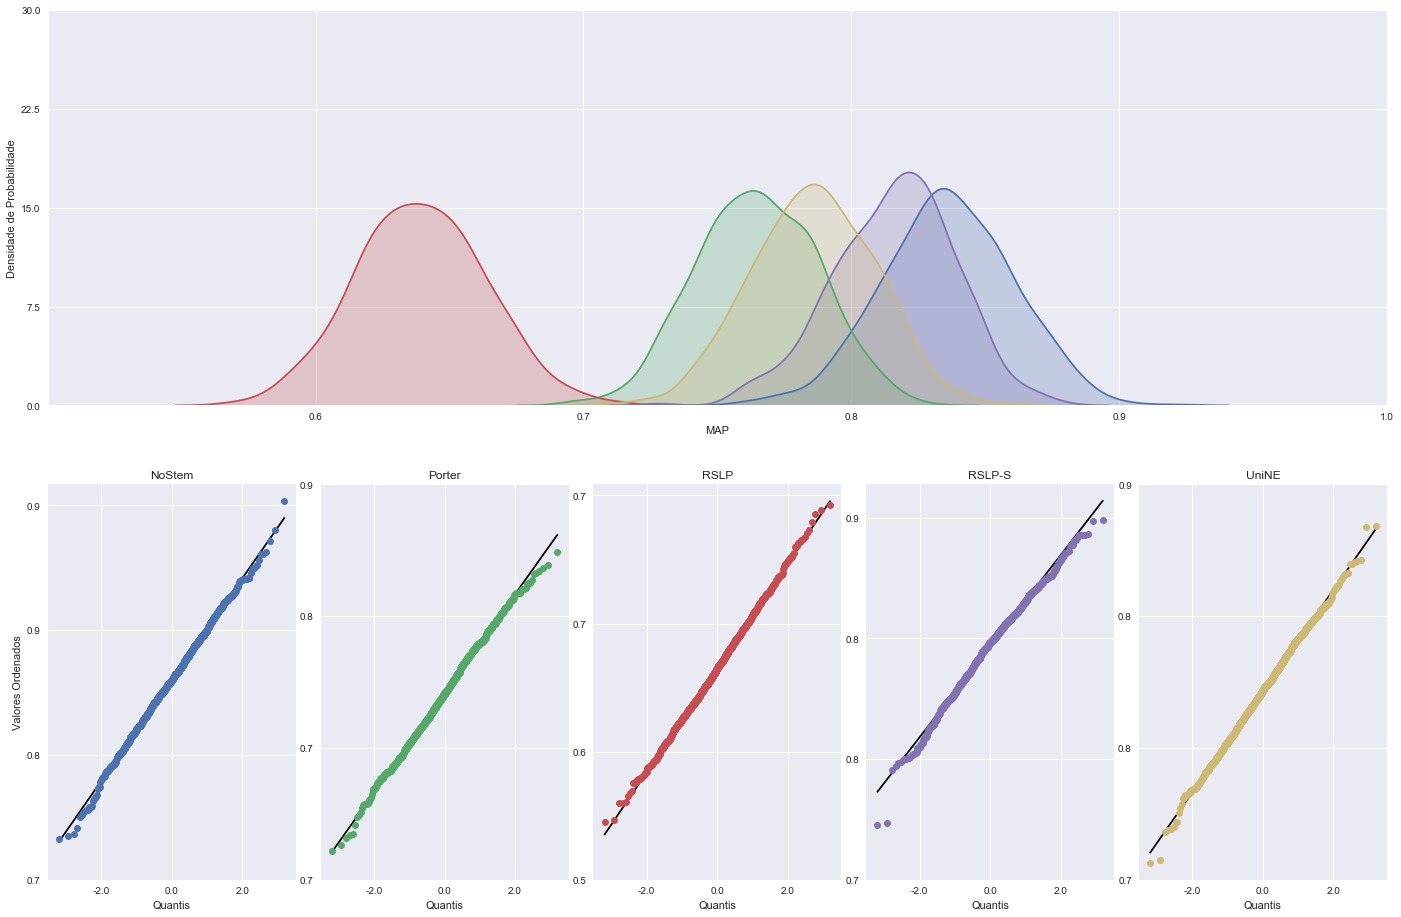

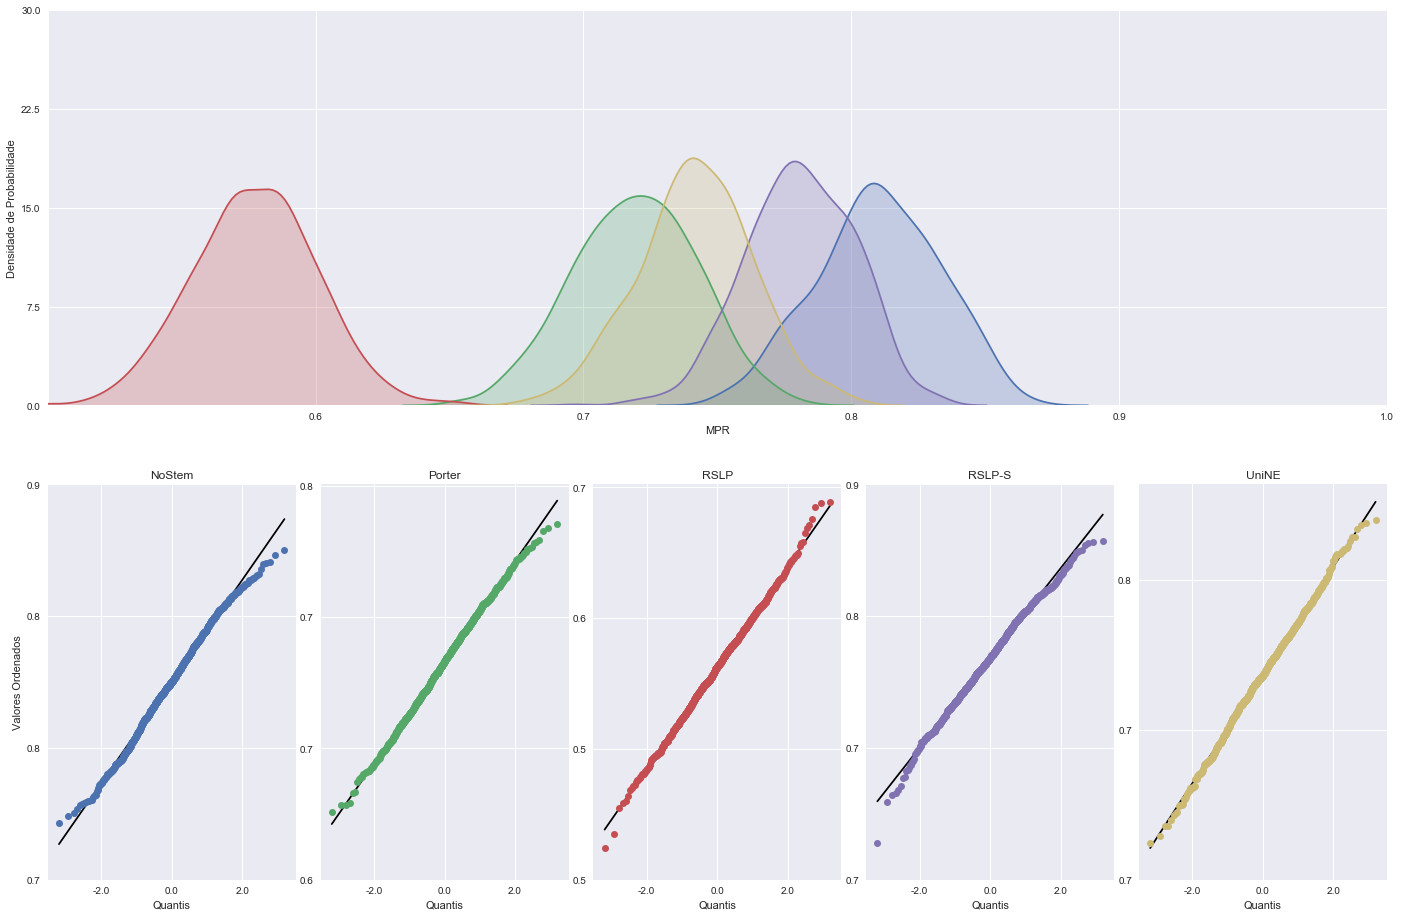

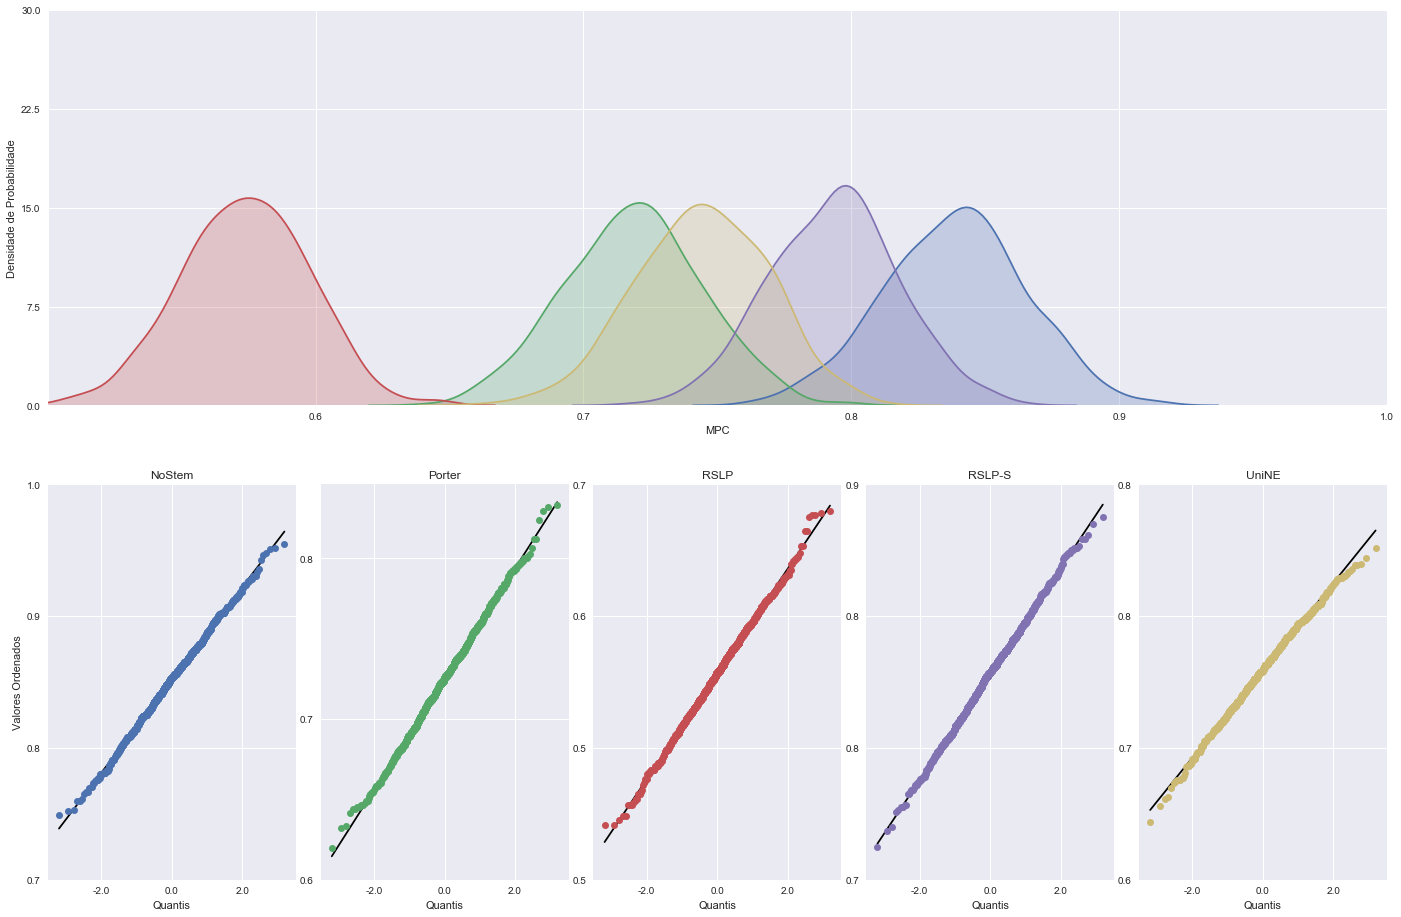

In [8]:
plot_kde_normality(experimento2, 'ASG')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0937  -0.0963 -0.0911  True 
NoStem  RSLP  -0.1801  -0.1827 -0.1774  True 
NoStem RSLP-S -0.0352  -0.0378 -0.0325  True 
NoStem UniNE  -0.0136  -0.0162 -0.0109  True 
Porter  RSLP  -0.0864   -0.089 -0.0838  True 
Porter RSLP-S  0.0585   0.0559  0.0611  True 
Porter UniNE   0.0801   0.0775  0.0827  True 
 RSLP  RSLP-S  0.1449   0.1423  0.1475  True 
 RSLP  UniNE   0.1665   0.1639  0.1691  True 
RSLP-S UniNE   0.0216   0.019   0.0242  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.1498  -0.1526  -0.147  True 
NoStem  RSLP  -0.2325  -0.2353 -0.2297  True 
NoStem RSLP-S -0.0504  -0.0532 -0.0476  True 
NoStem UniNE  -0.0392   -0.042 -0.0364  True 
Porter  RSLP  -0.0827  -

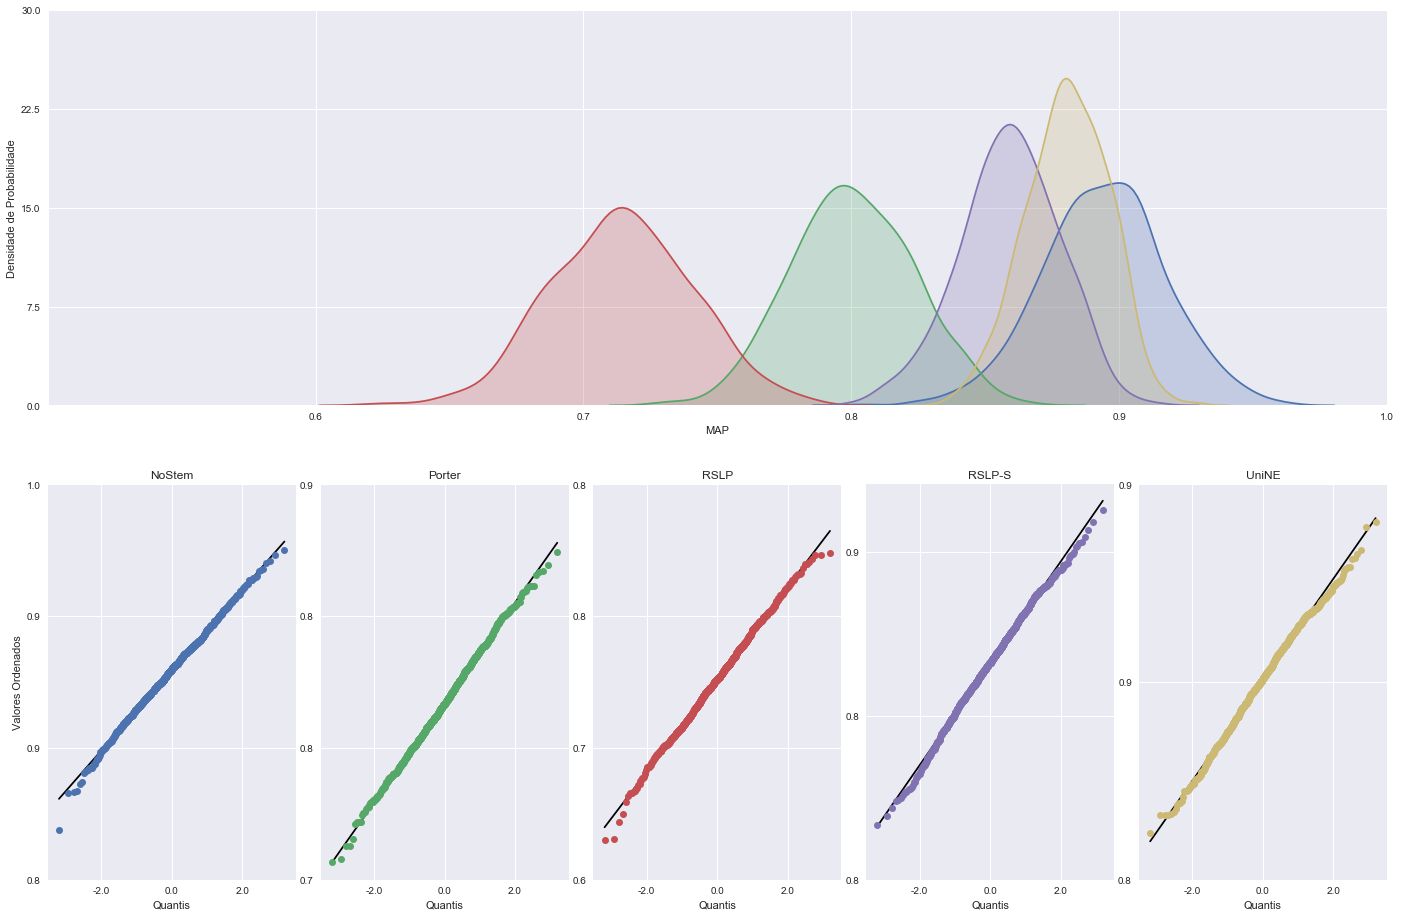

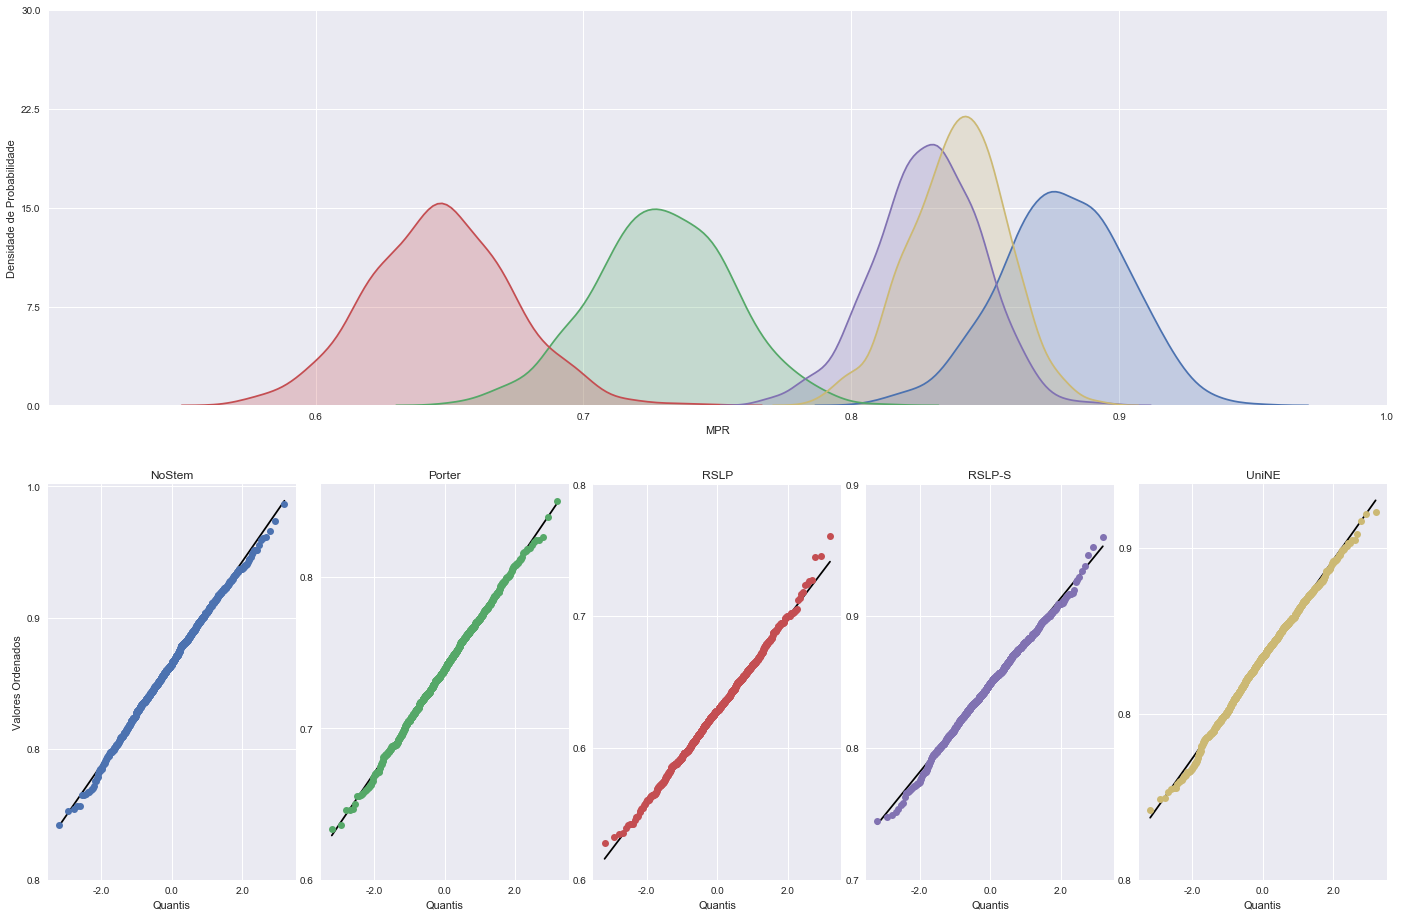

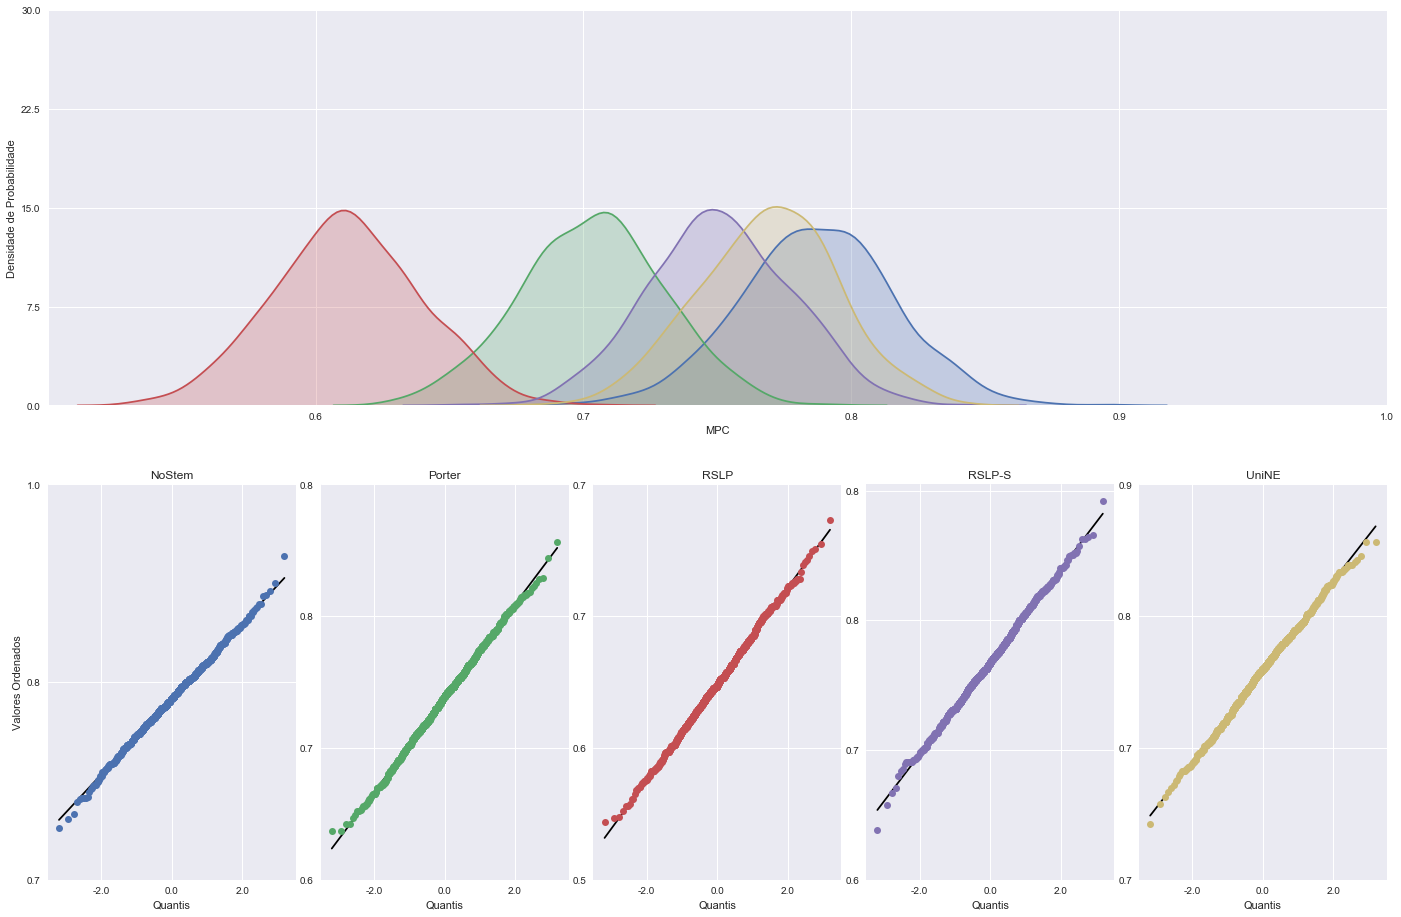

In [9]:
plot_kde_normality(experimento2, 'DSG')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0263  -0.0293 -0.0232  True 
NoStem  RSLP  -0.0477  -0.0507 -0.0446  True 
NoStem RSLP-S  0.0254   0.0224  0.0284  True 
NoStem UniNE   0.0538   0.0508  0.0568  True 
Porter  RSLP  -0.0214  -0.0244 -0.0184  True 
Porter RSLP-S  0.0517   0.0487  0.0547  True 
Porter UniNE   0.0801   0.077   0.0831  True 
 RSLP  RSLP-S  0.0731   0.0701  0.0761  True 
 RSLP  UniNE   0.1015   0.0985  0.1045  True 
RSLP-S UniNE   0.0284   0.0254  0.0314  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0644  -0.0673 -0.0615  True 
NoStem  RSLP  -0.0976  -0.1005 -0.0946  True 
NoStem RSLP-S -0.0017  -0.0046  0.0012 False 
NoStem UniNE   0.0106   0.0076  0.0135  True 
Porter  RSLP  -0.0331  -

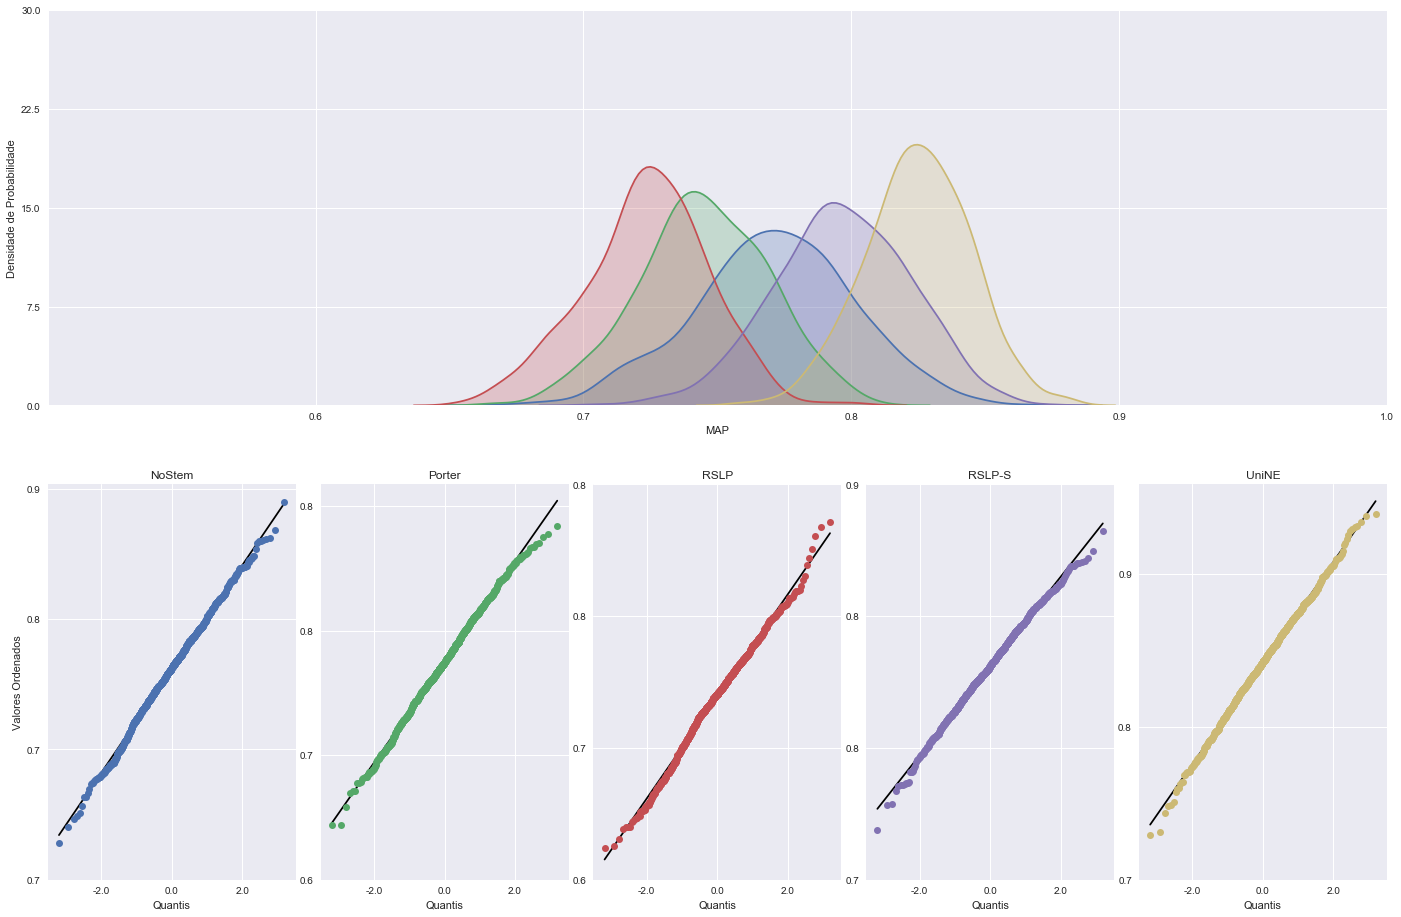

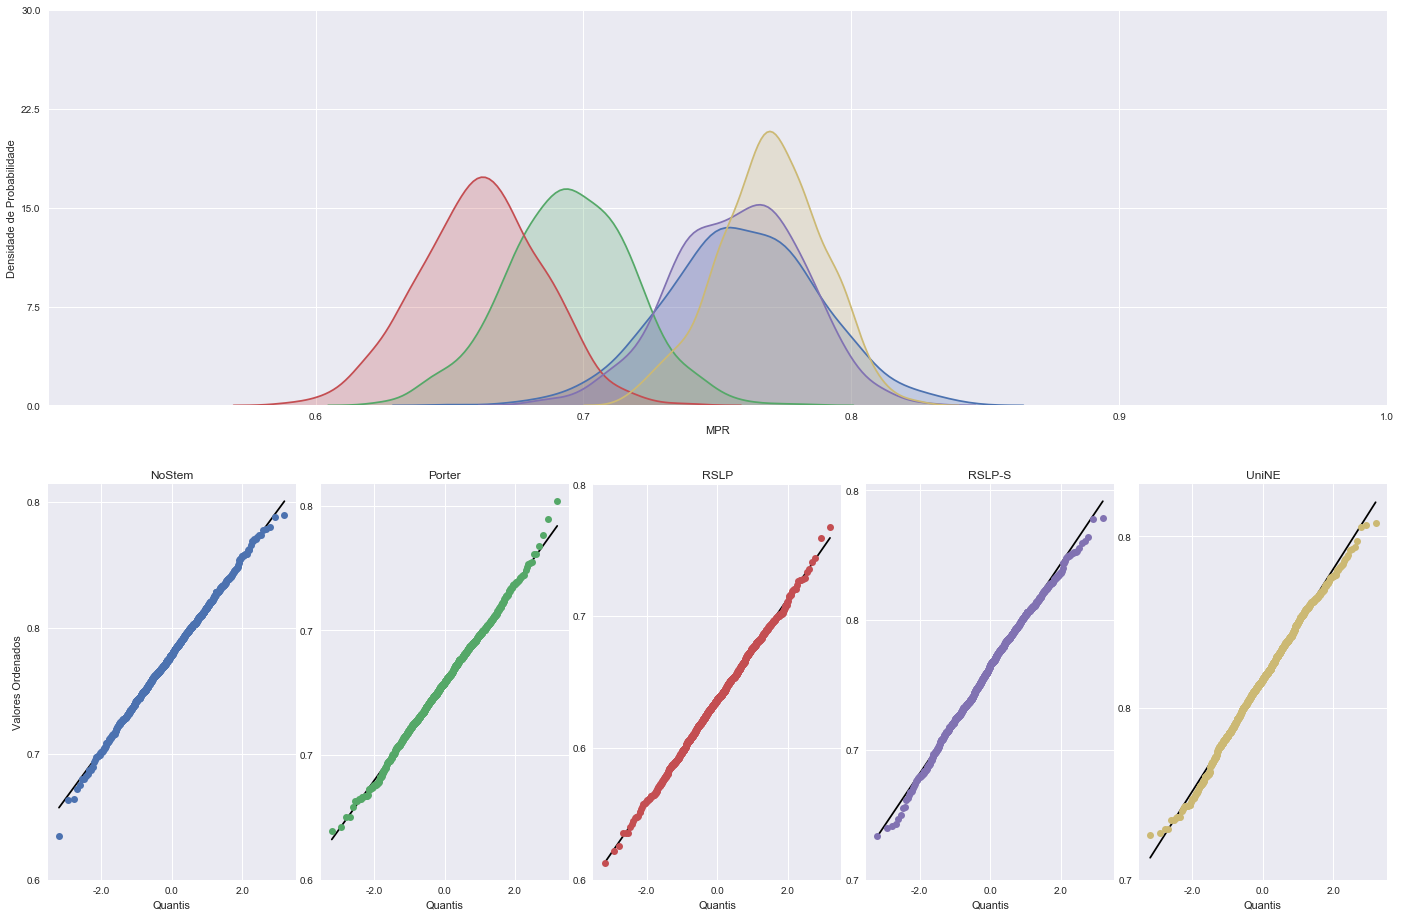

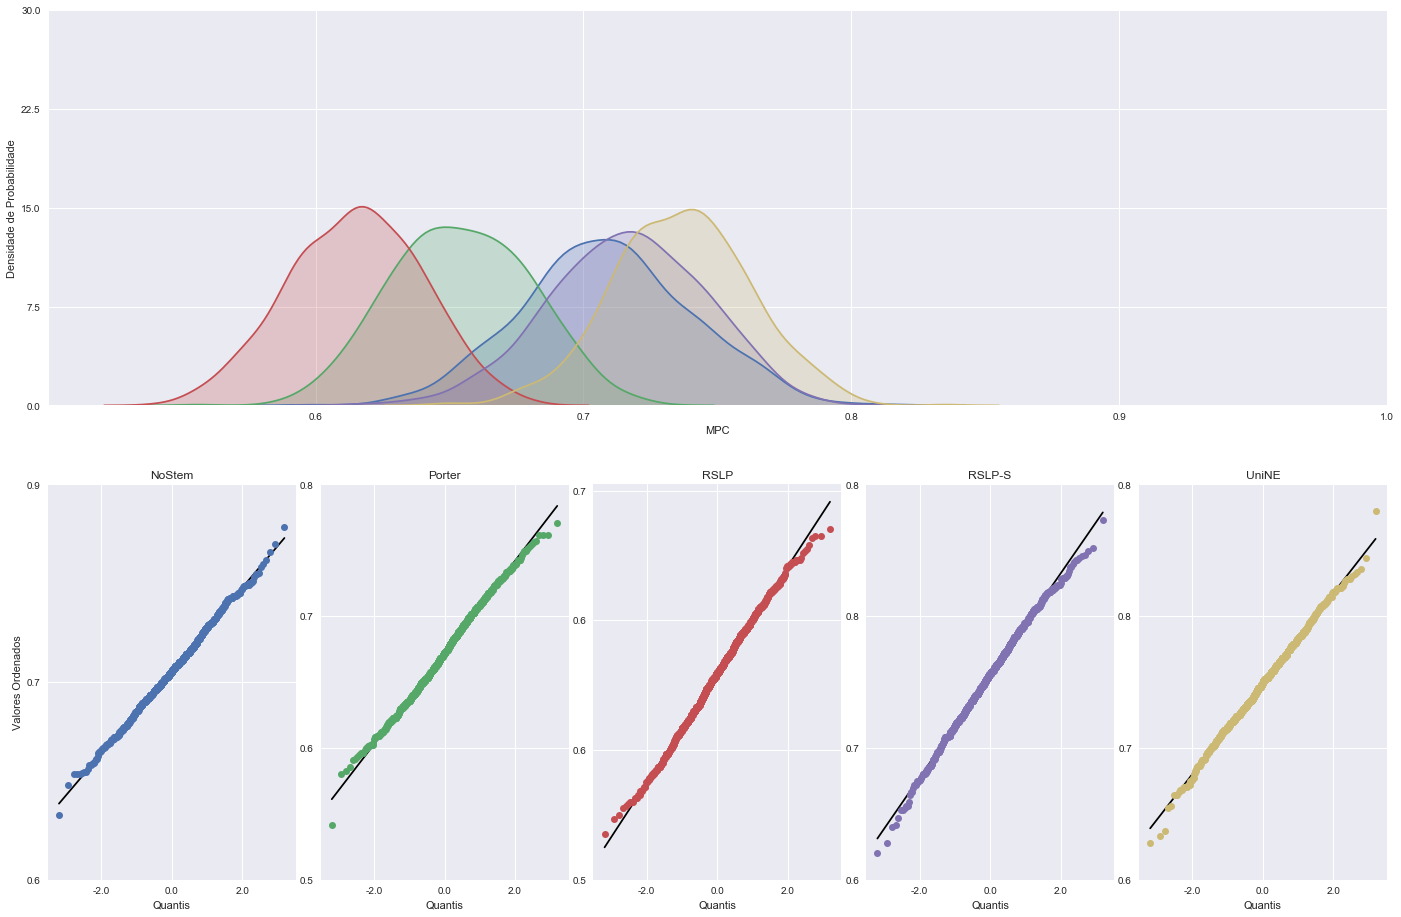

In [10]:
plot_kde_normality(experimento2, 'ATR')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter  -0.009  -0.0116 -0.0064  True 
NoStem  RSLP  -0.1071  -0.1097 -0.1046  True 
NoStem RSLP-S -0.0032  -0.0058 -0.0006  True 
NoStem UniNE  -0.0183  -0.0209 -0.0158  True 
Porter  RSLP  -0.0981  -0.1007 -0.0956  True 
Porter RSLP-S  0.0058   0.0032  0.0083  True 
Porter UniNE  -0.0094  -0.0119 -0.0068  True 
 RSLP  RSLP-S  0.1039   0.1014  0.1065  True 
 RSLP  UniNE   0.0888   0.0862  0.0913  True 
RSLP-S UniNE  -0.0151  -0.0177 -0.0126  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter  -0.046  -0.0487 -0.0432  True 
NoStem  RSLP   -0.16   -0.1628 -0.1573  True 
NoStem RSLP-S -0.0416  -0.0444 -0.0389  True 
NoStem UniNE  -0.0634  -0.0661 -0.0606  True 
Porter  RSLP  -0.1141  -

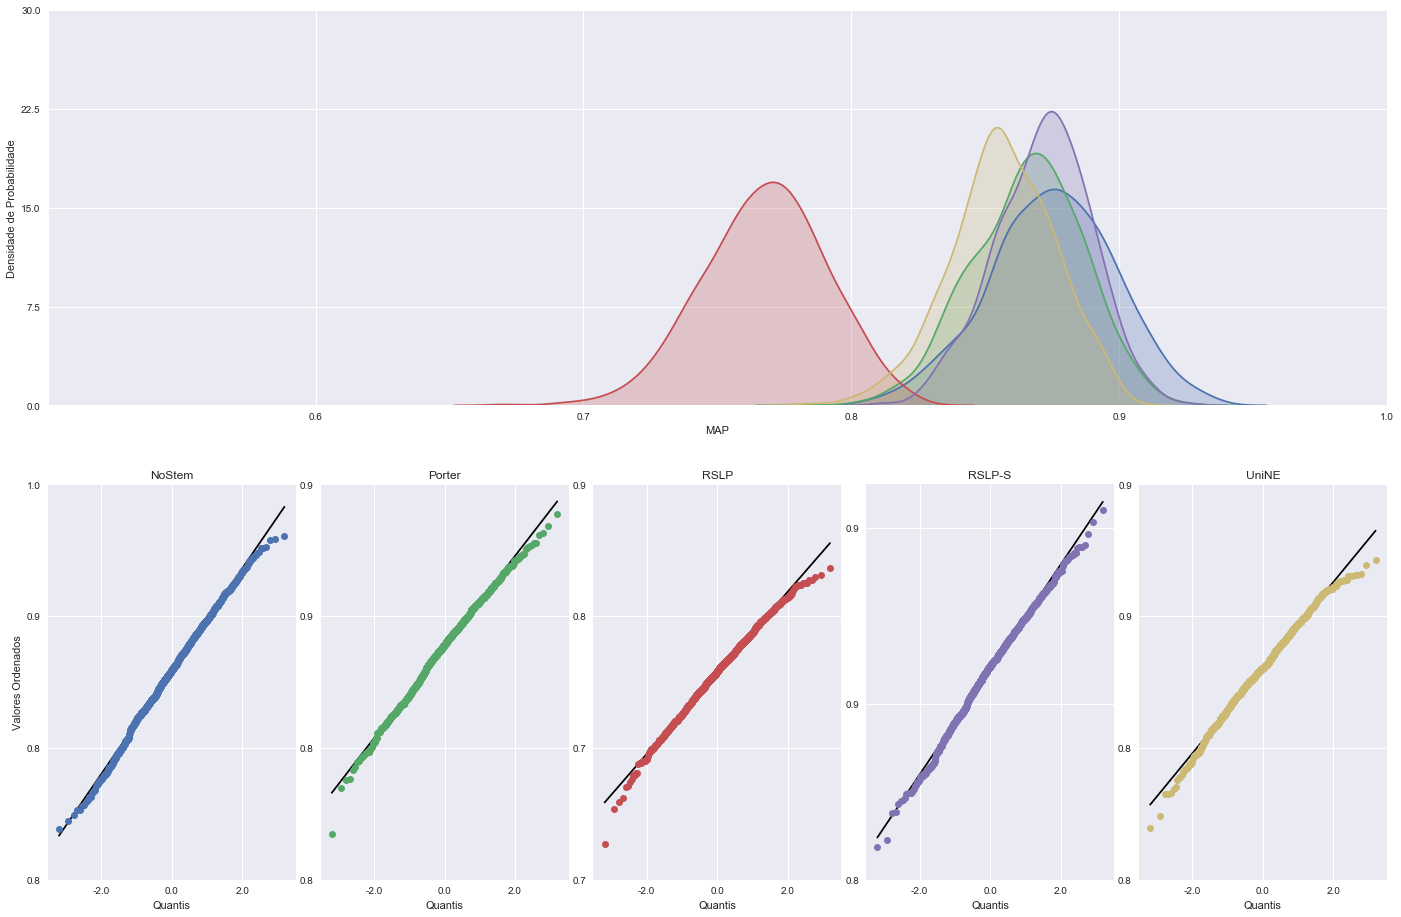

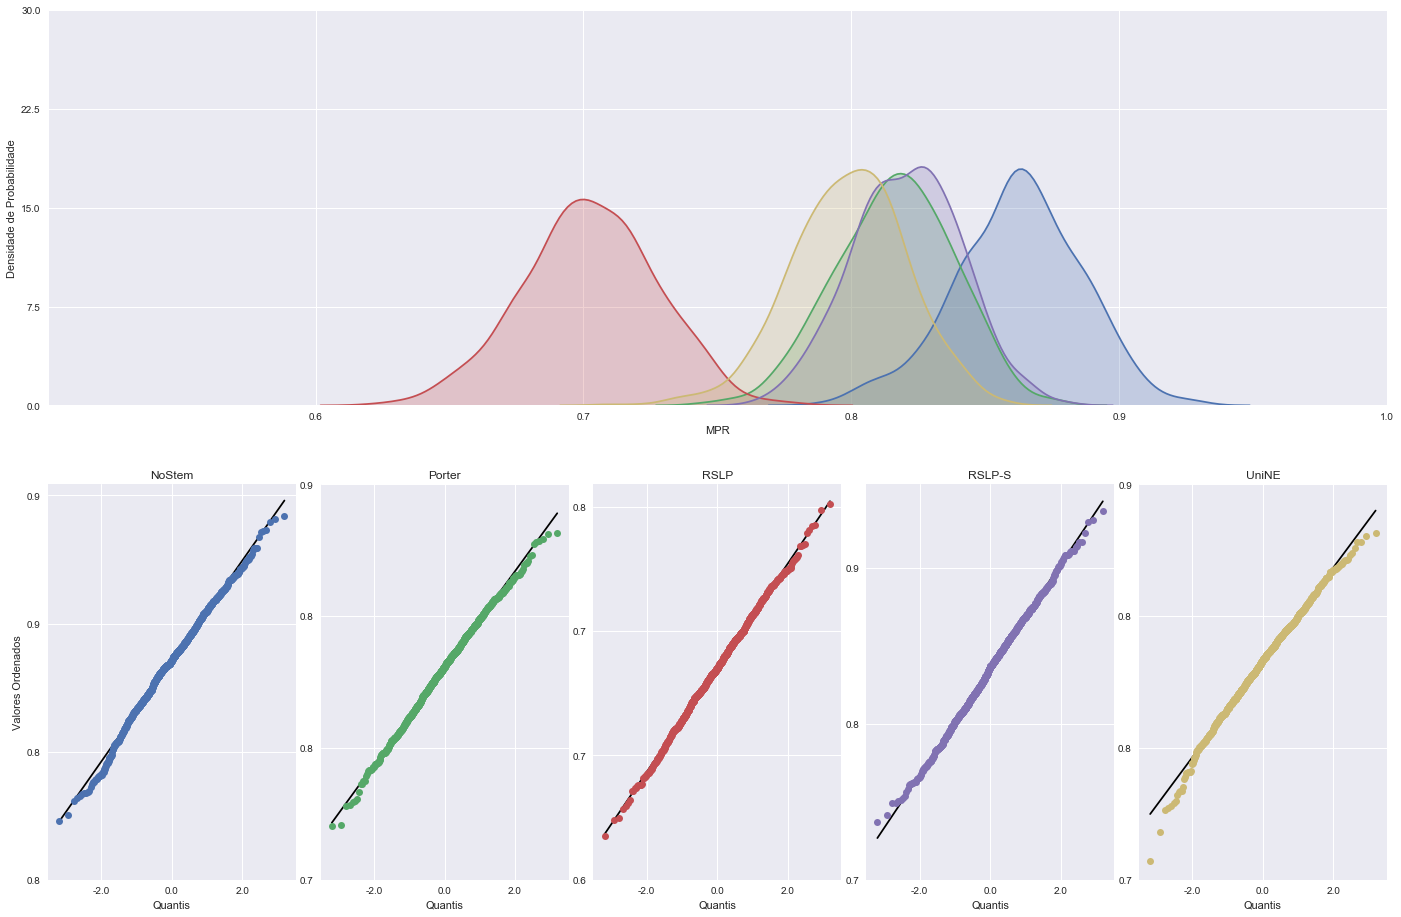

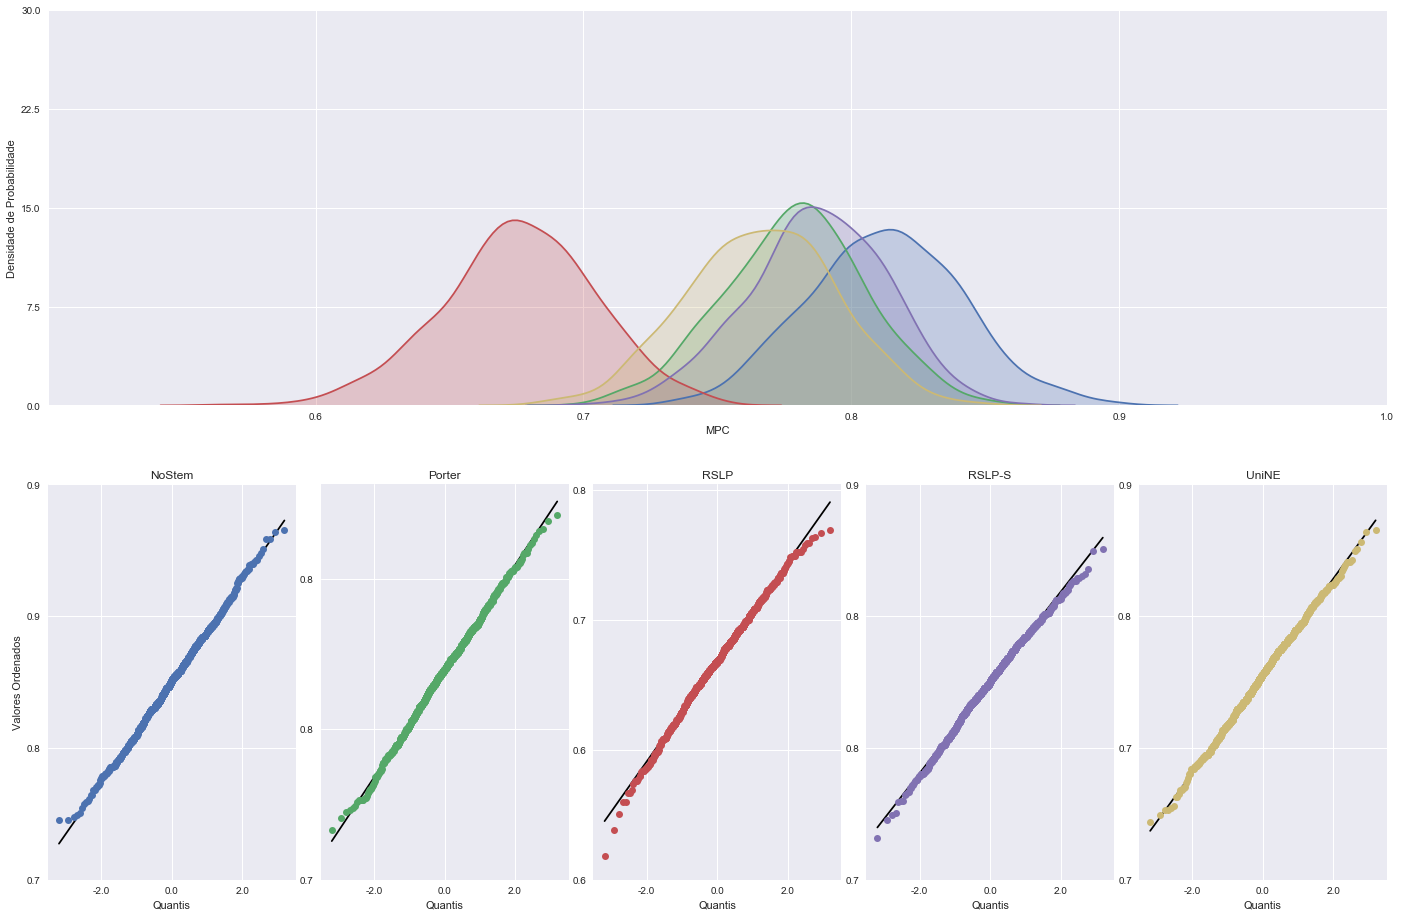

In [11]:
plot_kde_normality(experimento2, 'DTR')